# Image classification with VGG16 BN

In [1]:
!pip install pytorch-lightning torchvision lightning[extra]

In [2]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from pytorch_lightning.callbacks import EarlyStopping
import matplotlib.pyplot as plt

A custom Pytorch Dataset class is created to load the coral images from the file paths HEALTHY_IMAGES_DIR and BLEACHED_IMAGES_DIR.
The subfolders contain images of healthy and bleached corals.

In [3]:
# Define CoralDataset class
class CoralDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Define file paths
HEALTHY_IMAGES_DIR = "./data/healthy_corals"
BLEACHED_IMAGES_DIR = "./data/bleached_corals"

# Image paths and labels
healthy_image_paths = [os.path.join(HEALTHY_IMAGES_DIR, img) for img in os.listdir(HEALTHY_IMAGES_DIR) if os.path.isfile(os.path.join(HEALTHY_IMAGES_DIR, img))]
bleached_image_paths = [os.path.join(BLEACHED_IMAGES_DIR, img) for img in os.listdir(BLEACHED_IMAGES_DIR) if os.path.isfile(os.path.join(BLEACHED_IMAGES_DIR, img))]

image_paths = healthy_image_paths + bleached_image_paths
labels = [0] * len(healthy_image_paths) + [1] * len(bleached_image_paths)

The datasets is splitted into training (80%), validation (10%) and testing (10%).
Training data is used for model learning, the validation data evaluates the performance during training and the data assesses the final model performance.

In [4]:
# Split dataset into training (80%), validation (10%), and testing (10%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, random_state=42)

print('Dataset was successfully split into training, validation, and testing sets')

Dataset was successfully split into training, validation, and testing sets


Image data is preprocessed for training, to make the model more robust:
* Images are resized to 224x224 pixels, this matches the expected intput size for the VGG16 model.
* Images are converted from a PIL format to PyTorch tensor, because PyTorch models operate on tensors and not images.
* Pixel intensity values are adjusted to match the mean and standard deviation of the ImageNet dataset. VGG16 is pretrained on ImageNet and expects input data with similar statistics, otherwise the trianing migth be unstable or converge slowly
* Images are randomly flipped horizontally to generalize models for features that are horizontally symmetric.
* The brightness and contrast of the images is randomly adjusted to help with lighting variations
* Images are randomly rotated by +- 10 degrees to simulate real world situations

In [5]:
# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(10)
])

# Create datasets
train_dataset = CoralDataset(train_paths, train_labels, transform=data_transforms)
val_dataset = CoralDataset(val_paths, val_labels, transform=data_transforms)
test_dataset = CoralDataset(test_paths, test_labels, transform=data_transforms)

Dataloaders are created to feed the data to the model in batches to make the training more efficient

In [6]:
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

VGG16_BN model is defined which is pre-trained on ImageNet.
Following steps are defined in the model:
* Training Step: Calculates training loss and logs it.
* Validation Step: Calculates validation loss and accuracy and logs both.
* Optimizers: Uses Adam with lr=0.001 and StepLR scheduler for gradual learning rate reduction.

In [7]:
# Define model
class CoralClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super(CoralClassifier, self).__init__()
        self.model = models.vgg16_bn(weights="VGG16_BN_Weights.DEFAULT")
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)
        loss = self.loss_fn(preds, labels)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)
        loss = self.loss_fn(preds, labels)
        acc = (preds.argmax(dim=1) == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        return [optimizer], [scheduler]
    

Callback for metrics logging is defined to log training/validation losses and accuracy after each epoch.
The metrics are also stored for visualisation purposes.

In [8]:
# Enable optimized precision for CUDA Tensor Cores
torch.set_float32_matmul_precision("medium")

# Log Training Loss and Validation Accuracy per Epoch
train_losses = []
val_losses = []
val_accuracies = []

class CollectMetricsCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Epoch {trainer.current_epoch + 1}:")
        # Collect training loss
        train_loss = trainer.callback_metrics.get("train_loss", None)
        if train_loss is not None:
            print(f"Train Loss: {train_loss:.4f}")
            train_losses.append(train_loss.item())
            
        # Collect validation loss and accuracy
        val_loss = trainer.callback_metrics.get("val_loss", None)
        val_acc = trainer.callback_metrics.get("val_acc", None)
        if val_acc is not None:
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}")
            val_accuracies.append(val_acc.item())

Model and trainer are defined.
The trainer manages training loops, validation checks, logging and callbacks.
GPU acceleration (accelerator="gpu") is used for faster training and it logs metrics every batch (log_every_n_steps=1).
To avoid overfitting early stopping is added.

In [9]:
# Initialize model
model = CoralClassifier(num_classes=2)

# Define early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5)

# Initialize trainer
trainer = pl.Trainer(max_epochs=30, accelerator="gpu", devices=1, log_every_n_steps=1, callbacks=[early_stopping, CollectMetricsCallback()])

# Train the model
trainer.fit(model, train_dataloader, val_dataloader)
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | VGG              | 134 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.109   Total estimated model params size (MB)
56        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1:
Train Loss: 0.9321
Validation Loss: 0.9122, Validation Accuracy: 0.67


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2:
Train Loss: 0.7713
Validation Loss: 0.7014, Validation Accuracy: 0.67


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3:
Train Loss: 0.3717
Validation Loss: 0.6702, Validation Accuracy: 0.58


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4:
Train Loss: 0.5635
Validation Loss: 0.6990, Validation Accuracy: 0.60


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5:
Train Loss: 0.4027
Validation Loss: 0.6059, Validation Accuracy: 0.65


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6:
Train Loss: 0.5875
Validation Loss: 0.6173, Validation Accuracy: 0.71


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7:
Train Loss: 0.4547
Validation Loss: 0.4319, Validation Accuracy: 0.76


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8:
Train Loss: 0.1382
Validation Loss: 0.4580, Validation Accuracy: 0.74


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9:
Train Loss: 0.7342
Validation Loss: 0.5604, Validation Accuracy: 0.75


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10:
Train Loss: 0.6012
Validation Loss: 0.5601, Validation Accuracy: 0.73


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11:
Train Loss: 0.4656
Validation Loss: 0.4917, Validation Accuracy: 0.74


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12:
Train Loss: 1.3726
Validation Loss: 0.5102, Validation Accuracy: 0.73


Results are visualized to provide insights into the model performance.
Training loss and validation accuracy are plotted over the epochs

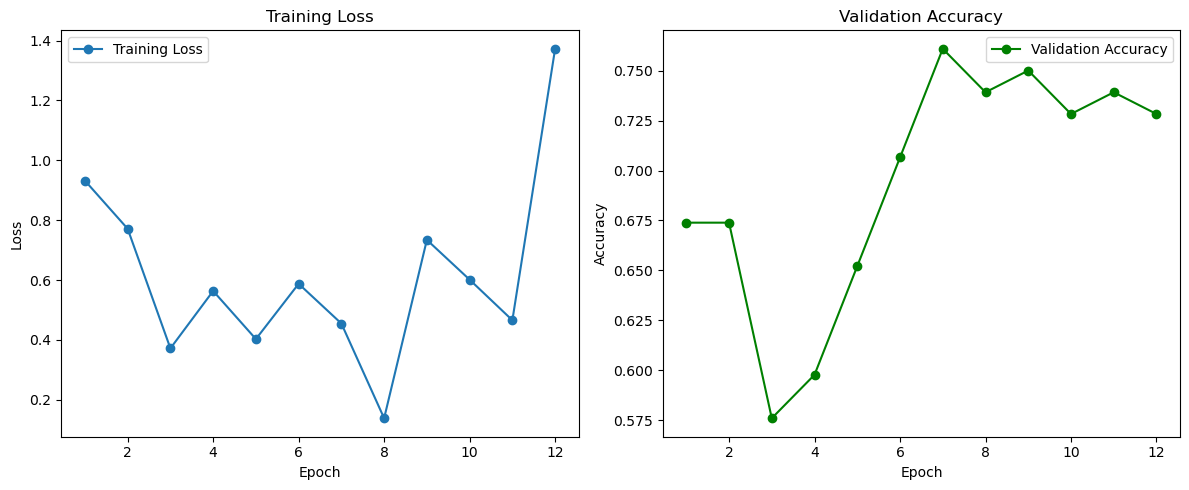

In [10]:
# visualize loss and accuracy
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker="o", label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, marker="o", label="Validation Accuracy", color="g")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
    